<h2> Welcome to MARK5826 Week 4!</h2>

Lecturer In Charge: Junbum Kwon;Teaching Assistant: Daniel Han-Chen & James Lin

In week 3, we focused on Recommendation Algorithms!

This week (week 4), we will focus on **CONTENT OPTIMIZATION**. This week is the first week where we will use **machine learning**.

<h2>AIM</h2>

Given movie data, find out and predict revenue / ratings, and understand WHAT contributes to the prediction.

<h2>TABLEAU</h2>

We will be also using TABLEAU this week. Next week also.

<h2>ASSIGNMENT 1 (week 3 to 5) 7 marks - DUE SATURDAY WEEK 5 10pm</h2>

Assignment 1 is due Saturday week 5 10pm. We need you to submit a URL / LINK to your assignment notebook on Kaggle.

IT MUST BE **PUBLIC**. Also, download the Kaggle file, and upload it to Moodle by 10pm Saturday week 5.

<h2> Suggestions from Previous Weeks </h2>

1. **|Slides|** We will upload the slides through email / moodle before the lectures!
2. **|Applications|** Week 1 was intro. Week 2+ will be all industry applications.
3. **|Lab Delivery|**  Speaking will be slower now (and content has been cut back a lot. We will explain more --> more quality over quantity).
4. **|Too fast|** We will go slowly on the hard parts of the class. In fact, we will go through how to do Lab Questions as a class.
5. **|Heavy Content|** Sorry about the overwhelming content! I'm sure from week 2 onwards, the code you'll see should look familiar.
6. **|Slow Computers|** Some people's computers are slow. We have decided to optimise the code below (removing superfluous code)
7. **|Heavy Content|** Lab Organisation has been improved, with one streamlined marking system.


<h2>Week Topics</h2>

(You can click the links below)

[SKIP BELOW CODE TO CONTENT](#Content)
<hr>

1.[Reading in Data](#Content)

2.[Plotting and Tabulating - Tableau](#Plotting and Tabulating)

3.[Data Cleaning - Natural Language Processing](#Data Cleaning - Natural Language Processing)

4.[Machine Learning - Supervised Learning](#Machine Learning - Supervised Learning)

5.[Machine Learning - Interpretation Traps](#Machine Learning - Interpretation Traps)

6.[Lab Questions](#Lab)

[<h1>CLICK to SKIP BELOW CODE TO CONTENT</h1>](#Content)

In [1]:
import pandas as pd, numpy as np, os, gc, matplotlib.pyplot as plt, seaborn as sb, re, warnings, calendar, sys
from numpy import arange
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore'); np.set_printoptions(suppress=True); pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x); pd.options.display.max_rows = 15
global directory; directory = '../input'

def files(): return os.listdir(directory)

def read_clean(data):
    data.columns = [str(x.lower().strip().replace(' ','_')) for x in data.columns]
    seen = {}; columns = []; i = 0
    for i,x in enumerate(data.columns):
        if x in seen: columns.append(x+'_{}'.format(i))
        else: columns.append(x)
        seen[x] = None
        
    for x in data.columns[data.count()/len(data) < 0.0001]: del data[x];
    gc.collect();
    try: data = data.replace({'':np.nan,' ':np.nan});
    except: pass;
    
    if len(data) < 10000: l = len(data);
    else: l = 10000;
    sample = data.sample(l);size = len(sample);
    
    for x in sample.columns:
        ints = pd.to_numeric(sample[x], downcast = 'integer', errors = 'coerce')
        if ints.count()/size > 0.97:
            minimum = ints.min()
            if minimum > 0: data[x] = pd.to_numeric(data[x], downcast = 'unsigned', errors = 'coerce')
            else: data[x] = pd.to_numeric(data[x], downcast = 'integer', errors = 'coerce')
        else:
            floats = pd.to_numeric(sample[x], downcast = 'float', errors = 'coerce')
            if floats.count()/size > 0.97: data[x] = pd.to_numeric(data[x], downcast = 'float', errors = 'coerce')
            else:
                dates = pd.to_datetime(sample[x], errors = 'coerce')
                if dates.count()/size > 0.97: data[x] = pd.to_datetime(data[x], errors = 'coerce')
    return data.reset_index(drop = True)

def read(x):
    '''Kaggle Reading in CSV files.
    Just type read('file.csv'), and you'll get back a Table.'''
    
    file = '{}/{}'.format(directory,x)
    try:     data = pd.read_csv(file)
    except:  data = pd.read_csv(file, encoding = 'latin-1')
    return read_clean(data)

def tally(column, minimum = 0, top = None, graph = False, percent = False, multiple = False, lowercase = False, min_count = 1):
    '''Provides a tally count of all values in a COLUMN.
        1. minimum  =  (>0)          Least count of item to show.
        2. top      =  (-1,>0)       Only show top N objects
        3. graph    =  (False,True)  Show bar graph of results
        4. percent  =  (False,>0)    Instead of showing counts, show percentages of total count
        
       multiple = False/True.
       If True, counts and tallies objects in list of lists (Count Vectorizer)
       
       lowercase = True / False.
       If True, lowers all text firsrt. So A == a
       
       min_count >= 1
       If a column sum for tag has less than min_count, discard whole column
    '''
    if multiple == False:
        counts = column.value_counts().astype('uint')
        counts = counts[counts >= minimum][:top]
        counts = pd.DataFrame(counts).reset_index()
        counts.columns = [column.name, 'tally']
        if percent: 
            counts['tally'] /= counts['tally'].sum()/100
            counts['tally'] = counts['tally']
        if graph:
            C = counts[::-1]
            C.plot.barh(x = column.name, y = 'tally', legend = False); plt.show();
        return counts
    else:
        from sklearn.feature_extraction.text import CountVectorizer
        column = column.fillna('<NAN>')
        if type(column.iloc[0]) != list: column = column.apply(lambda x: [x])
        counter = CountVectorizer(lowercase = lowercase, tokenizer = lambda x: x, dtype = np.uint32, min_df = min_count)
        counter.fit(column)
        counts = pd.DataFrame(counter.transform(column).toarray())
        counts.columns = [column.name+'_('+str(x)+')' for x in counter.get_feature_names()]
        return counts
    
    
def describe(data):
    '''Provides an overview of your data
        1. dtype    =  Column type
        2. missing% =  % of the column that is missing
        3. nunique  =  Number of unique values in column
        4. top3     =  Top 3 most occuring items
        5. min      =  Minimum value. If not a number column, then empty
        6. mean     =  Average value. If not a number column, then empty
        7. median   =  Middle value. So sort all numbers, and get middle. If not a number column, then empty
        8. max      =  Maximum value. If not a number column, then empty
        9. sample   =  Random 2 elements
        10. name    =  Column Name
    '''
    dtypes = dtype(data)
    length = len(data)
    missing = ((length - data.count())/length*100)
    
    N = [];    most3 = []
    for dt,col in zip(dtypes,data.columns):
        if dt != 'datetime':
            U = data[col].value_counts()
            N.append(len(U))
            if U.values[0] > 1: most3.append(U.index[:3].tolist())
            else: most3.append([]);
        else: N.append(0); most3.append([]);
            
    df = pd.concat([dtypes, missing], 1)
    df.columns = ['dtype','missing%']
    df['nunique'] = N; df['top3'] = most3
    
    numbers = list(data.columns[df['dtype'].isin(('uint','int','float'))])
    df['min'] = data.min()
    df['mean'] = data[numbers].mean()
    df['median'] = data[numbers].median()
    df['max'] = data.max()
    df['sample'] = data.apply(lambda x : x.sample(2).values.tolist())
    df['name'] = list(data.columns)
    return df.sort_values(['missing%', 'nunique', 'dtype'], ascending = [False, False, True]).reset_index(drop = True)


def Checker(x):
    if type(x) is pd.DataFrame: return 0
    elif type(x) is pd.Series: return 1
    else: return -1

def columns(data): return list(data.columns)
def rows(data): return list(data.index)
def index(data): return list(data.index)
def head(data, n = 10): return data.head(n)
def tail(data, n = 10): return data.tail(n)
def sample(data, n = 10): return data.sample(n)

def dtype(data):
    what = Checker(data)
    if what == 0:
        dtypes = data.dtypes.astype('str')
        dtypes = dtypes.str.split(r'\d').str[0]
    else:
        dtypes = str(data.dtypes)
        dtypes = re.split(r'\d', dtypes)[0]
    return dtypes

def mean(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].mean()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.mean()
        else: return np.nan
    else:
        try:     return np.nanmean(data)
        except:  return np.nan
        
def std(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].std()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.std()
        else: return np.nan
    else:
        try:     return np.nanstd(data)
        except:  return np.nan
        
def var(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].var()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.var()
        else: return np.nan
    else:
        try:     return np.nanvar(data)
        except:  return np.nan
        
def log(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        x = np.log(data[numbers])
        x[np.isinf(x)] = np.nan
        return pd.Series(x)
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt:
            x = np.log(data)
            x[np.isinf(x)] = np.nan
            return x
        else: return np.nan
    else:
        try:
            x = np.log(data)
            x[np.isinf(x)] = np.nan
            return x
        except:  return np.nan
        
def median(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].median()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.median()
        else: return np.nan
    else:
        try:     return np.nanmedian(data)
        except:  return np.nan
        
def minimum(data):
    what = Checker(data)
    if what == 0:      return data.min()
    elif what == 1:    return data.min()
    else:              return np.min(data)
        
def maximum(data):
    what = Checker(data)
    if what == 0:      return data.max()
    elif what == 1:    return data.max()
    else:              return np.max(data)
    
def missing(data):
    what = Checker(data)
    if what >= 0:      return pd.isnull(data)
    else:              return np.isnan(data)
    
def count(data):
    what = Checker(data)
    if what >= 0:      return data.count()
    else:              return len(data)
    
def nunique(data):
    what = Checker(data)
    if what >= 0:      return data.nunique()
    else:              return len(np.unique(data))
    
def unique(data):
    if type(data) is pd.DataFrame:
        uniques = []
        for x in data.columns:
            uniques.append(data[x].unique())
        df = pd.Series(uniques)
        df.index = data.columns
        return df
    elif type(data) is pd.Series: return data.unique()
    else:              return np.unique(data)
    
def total(data):
    what = Checker(data)
    _dt = ('uint','int','float')
    if what == 0:
        dtypes = dtype(data)
        numbers = data.columns[dtypes.isin(_dt)]
        return data[numbers].sum()
    elif what == 1:
        dtypes = dtype(data)
        if dtypes in _dt: return data.sum()
        else: return np.nan
    else:
        try:     return np.nansum(data)
        except:  return np.nan
        
def time_number(date): return hours(date)+minutes(date)/60+seconds(date)/60**2
def hours_minutes(date): return hours(date)+minutes(date)/60
def hours(date): return date.dt.hour
def minutes(date): return date.dt.minute
def seconds(date): return date.dt.second
def month(date): return date.dt.month
def year(date): return date.dt.year
def day(date): return date.dt.day
def weekday(date): return date.dt.weekday
def leap_year(date): return year(date).apply(calendar.isleap)
def date_number(date): return year(date)+month(date)/12+day(date)/(365+leap_year(date)*1)
def year_month(date): return year(date)+month(date)/12

def hcat(*columns):
    cols = []
    for c in columns:
        if c is None: continue;
        if type(c) in (list, tuple): 
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(i))
                else: cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(c))
        else: cols.append(c)
    return pd.concat(cols, 1)

def vcat(*columns):
    cols = []
    for c in columns:
        if c is None: continue;
        if type(c) in (list, tuple): 
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(i))
                else: cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series): cols.append(pd.Series(c))
        else: cols.append(c)
    return pd.concat(cols, 0)

def melt(data, columns):
    '''Converts a dataset into long form'''
    return data.melt(id_vars = columns)
    
def tabulate(*columns, method = 'count'):
    '''Splits columns into chunks, and counts the occurences in each group.
        Remember - tabulate works on the LAST column passed.
        Options:
            1. count            = Pure Count in group
            2. count_percent    = Percentage of Count in group
            3. mean             = Mean in group
            4. median           = Median in group
            5. max              = Max in group
            6. min              = Min in group
            7. sum_percent      = Percentage of Sum in group
        Eg:
            Apple | 1
            ---------
            Orange| 3
            ---------
            Apple | 2
            ---------
        Becomes:
            Apple | 1 | 1
            -------------
                  | 2 | 1
            -------------
            Orange| 3 | 1
        
        NOTE --------
            method can be a list of multiple options.
    '''
    if type(method) in (list, tuple):
        xs = []
        for x in method:
            g = tabulate(*columns, method = x)
            xs.append(g)
        xs = hcat(xs)
        xs = xs.T.drop_duplicates().T
        return read_clean(xs)        
    else:
        def percent(series):
            counts = series.count()
            return counts.sum()

        data = hcat(*columns)
        columns = data.columns.tolist()

        if method in ('count', 'count_percent'):
            groups = data.groupby(data.columns.tolist()).apply(lambda x: x[data.columns[-1]].count())

            if method == 'count_percent':
                groups = groups.reset_index()
                groups.columns = list(groups.columns[:-1])+['Group_Count']
                right = data.groupby(columns[:-1]).count().reset_index()
                right.columns = list(right.columns[:-1])+['Group_Sum']

                groups = pd.merge(left = groups, right = right, left_on = columns[:-1], right_on = columns[:-1])
                groups['Percent%'] = groups['Group_Count']/groups['Group_Sum']*100
                groups = groups[columns+['Percent%']]
                return groups

        elif method == 'mean': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].mean())
        elif method == 'median': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].median())
        elif method == 'max': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].max())
        elif method == 'min': groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].min())
        elif method == 'sum_percent':
            groups = data.groupby(data.columns.tolist()[:-1]).apply(lambda x: x[data.columns[-1]].sum()).reset_index()
            groups.columns = list(groups.columns[:-1])+['Group_Count']
            right = data.groupby(columns[:-1]).sum().reset_index()
            right.columns = list(right.columns[:-1])+['Group_Sum']

            groups = pd.merge(left = groups, right = right, left_on = columns[:-1], right_on = columns[:-1])
            groups['Sum%'] = groups['Group_Count']/groups['Group_Sum']*100
            groups = groups[cols+['Sum%']]
            return groups
        else:
            print('Method does not exist. Please choose count, count_percent, mean, median, max, min, sum_percent.'); return None;
        #except: print('Method = {}'.format(method)+' cannot work on Object, Non-Numerical data. Choose count.'); return None;

        groups = pd.DataFrame(groups)
        groups.columns = [method]
        groups.reset_index(inplace = True)
        return groups


def sort(data, by = None, how = 'ascending', inplace = False):
    ''' how can be 'ascending' or 'descending' or 'a' or 'd'
    It can also be a list for each sorted column.
    '''
    replacer = {'ascending':True,'a':True,'descending':False,'d':False}
    if by is None and type(data) is pd.Series:
        try:    x = replacer[how]
        except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
        return data.sort_values(ascending = x, inplace = inplace)
    elif type(how) is not list:
        try:    how = replacer[how]
        except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
    else:
        for x in how: 
            try:    x = replacer[x]
            except: print("how can be 'ascending' or 'descending' or 'a' or 'd'"); return None;
    return data.sort_values(by, ascending = how, inplace = inplace)

def keep(data, what, inplace = False):
    '''Keeps data in a column if it's wanted.
    Everything else is filled with NANs'''
    if type(what) not in (list,tuple,np.array,np.ndarray): what = [what]
    need = data.isin(what)
    if inplace: 
        df = data
        df.loc[~need] = np.nan
    else: 
        df = data.copy()
        df.loc[~need] = np.nan
        return df

def remove(data, what, inplace = False):
    '''Deletes data in a column if it's not wanted.
    Everything else is filled with NANs'''
    if type(what) not in (list,tuple): what = [what]
    need = data.isin(what)
    if inplace: 
        df = data
        df.loc[need] = np.nan
    else: 
        df = data.copy()
        df.loc[need] = np.nan
        return df
    
    
def ternary(data, condition, true, false = np.nan, inplace = False):
    '''C style ternary operator on column.
    Condition executes on column, and if true, is filled with some value.
    If false, then replaced with other value. Default false is NAN.'''
    try:
        execute = 'data {}'.format(condition)
        series = eval(execute)
        try: series = series.map({True:true, False:false})
        except: series = series.replace({True:true, False:false})
        return series
    except: print('Ternary accepts conditions where strings must be enclosed.\nSo == USD not allowed. == "USD" allowed.'); return False;

    
def locate(data, column):
    '''Use ternary to get result and then filter with notnull'''
    if dtype(column) == 'bool': return data.loc[column]
    return data.loc[column.notnull()]
    
def query(data, column = None, condition = None):
    '''Querying data based on conditions'''
    def Q(data, column, condition):
        if column is not None:
            if type(condition) in (np.array, np.ndarray, list, tuple, set):
                cond = keep(data[column], tuple(condition))
                cond = (cond.notnull())
            else: cond = ternary(data[column], condition, True, False)
            return data.loc[cond]
        else:
            if type(condition) in (np.array, np.ndarray, list, tuple, set):
                cond = keep(data, tuple(condition))
            else: cond = ternary(data, condition, True, False)
            return data.loc[cond]
    try:
        return Q(data, column, condition)
    except:
        condition = condition.replace('=','==')
        return Q(data, column, condition)
        
def keep_top(x, n = 5):
    '''Keeps top n (after tallying) in a column'''
    df = keep(x, tally(x)[x.name][:n].values)
    return df

def keep_bot(x, n = 5):
    '''Keeps bottom n (after tallying) in a column'''
    df = keep(x, tally(x)[x.name][:-n].values)
    return df


def remove_outlier(x, method = 'iqr', range = 1.5):
    '''Removes outliers in column with methods:
        1. mean     =    meean+range (normally 3.5)
        2. median   =    median+range (normally 3.5)
        3. iqr      =    iqr+range (normally 1.5)
    '''
    i = x.copy()
    if method == 'iqr':
        first = np.nanpercentile(x, 0.25)
        third = np.nanpercentile(x, 0.75)
        iqr = third-first
        i[(i > third+iqr*range) | (i < first-iqr*range)] = np.nan
    else:
        if method == 'mean': mu = np.nanmean(x)
        else: mu = np.nanmedian(x)
        std = np.nanstd(x)
        i[(i > mu+std*range) | (i < mu-std*range)] = np.nan
    return i


def cut(x, bins = 5, method = 'range'):
    '''Cut continuous column into parts.
        Method options:
            1. range
            2. quantile (number of quantile cuts)'''
    if method == 'range': return pd.cut(x, bins = bins, duplicates = 'drop')
    else: return pd.qcut(x, q = bins, duplicates = 'drop')
    
    
def plot(x, y = None, colour = None, column = None, data = None, size = 5, top = 10, wrap = 4, 
         subset = 5000, method = 'mean', quantile = True, bins = 10,
         style = 'lineplot', logx = False, logy = False, logc = False, power = 1):
    '''Plotting function using seaborn and matplotlib
        Options:
        x, y, colour, column, subset, style, method
        
        Plot styles:
            1. boxplot
            2. barplot
            3. tallyplot (counting number of appearances)
            4. violinplot (boxplot just fancier)
            5. lineplot (mean line plot)
            6. histogram
            7. scatterplot (X, Y must be numeric --> dates will be converted)
            8. bivariate (X, Y must be numeric --> dates will be converted)
            9. heatmap (X, Y will be converted into categorical automatically --> bins)
            10. regplot (X, Y must be numeric --> dates will be converted)
    '''
    if type(x) in (np.array,np.ndarray): x = pd.Series(x); x.name = 'x';
    if type(y) in (np.array,np.ndarray): y = pd.Series(y); y.name = 'y';
    if type(column) in (np.array,np.ndarray): column = pd.Series(column); column.name = 'column';
    if type(colour) in (np.array,np.ndarray): colour = pd.Series(colour); colour.name = 'colour';
        
    if type(x) == pd.Series: 
        data = pd.DataFrame(x); x = x.name
        if type(x) is not str:
            data.columns = [str(x)]
            x = str(x)
    if method == 'mean': estimator = np.nanmean
    elif method == 'median': estimator = np.nanmedian
    elif method == 'min': estimator = np.min
    elif method == 'max': estimator = np.max
    else: print('Wrong method. Allowed = mean, median, min, max'); return False;
    #----------------------------------------------------------
    sb.set(rc={'figure.figsize':(size*1.75,size)})
    dtypes = {'x':None,'y':None,'c':None,'col':None}
    names = {'x':None,'y':None,'c':None,'col':None}
    xlim = None
    #----------------------------------------------------------
    if data is not None:
        if type(x) is str: x = data[x];
        if type(y) is str: y = data[y]; 
        if type(colour) is str: colour = data[colour]; 
        if type(column) is str: column = data[column]; 
    if type(x) is str: print('Please specify data.'); return False;
    #----------------------------------------------------------
    if x is not None:
        dtypes['x'] = dtype(x); names['x'] = x.name
        if dtypes['x'] == 'object': x = keep_top(x, n = top)
        elif dtypes['x'] == 'datetime': x = date_number(x)
        if logx and dtype(x) != 'object': x = log(x)
    if y is not None: 
        dtypes['y'] = dtype(y); names['y'] = y.name
        if dtypes['y'] == 'object': y = keep_top(y, n = top)
        elif dtypes['y'] == 'datetime': y = date_number(y)
        if logy and dtype(y) != 'object': y = log(y)
    if colour is not None:
        dtypes['c'] = dtype(colour); names['c'] = colour.name
        if dtypes['c'] == 'object': colour = keep_top(colour, n = top)
        elif dtypes['c'] == 'datetime': colour = date_number(colour)
        if logc and dtype(colour) != 'object': colour = log(colour)
    if column is not None:
        dtypes['col'] = dtype(column); names['col'] = column.name
        if dtypes['col'] == 'object': column = keep_top(column, n = top)
        elif dtypes['col'] == 'datetime': column = date_number(column)
    #----------------------------------------------------------
    df = hcat(x, y, colour, column)
    if subset > len(df): subset = len(df)
    df = sample(df, subset)
    #----------------------------------------------------------
    if column is not None:
        if dtype(df[names['col']]) not in ('object', 'uint',' int') and nunique(df[names['col']]) > top: 
            if quantile: df[names['col']] = cut(df[names['col']], bins = bins, method = 'quantile')
            else: df[names['col']] = cut(df[names['col']], bins = bins, method = 'range')
    
    try: df.sort_values(names['y'], inplace = True);
    except: pass;
    #----------------------------------------------------------
    replace = {'boxplot':'box', 'barplot':'bar', 'tallyplot':'count', 'violinplot':'violin', 
               'lineplot': 'point', 'histogram':'lv'}
    
    if style == 'histogram' and y is None:
        plot = sb.distplot(df[names['x']].loc[df[names['x']].notnull()], bins = bins)
    elif style == 'lineplot' and y is None:
        plot = plt.plot(df[names['x']]);
        plt.show(); return;
    elif style == 'barplot' and y is None:
        plot = df.sort_values(names['x']).plot.bar();
        plt.show(); return;
    elif style in replace.keys():
        if dtype(df[names['x']]) not in ('object', 'uint',' int') and nunique(df[names['x']]) > top: 
            if quantile: df[names['x']] = cut(df[names['x']], bins = bins, method = 'quantile')
            else: df[names['x']] = cut(df[names['x']], bins = bins, method = 'range')
        
        if names['col'] is not None:
            plot = sb.factorplot(x = names['x'], y = names['y'], hue = names['c'], data = df, kind = replace[style], col = names['col'],
                             n_boot = 1, size = size, estimator = estimator, col_wrap = wrap)
        else:
            plot = sb.factorplot(x = names['x'], y = names['y'], hue = names['c'], data = df, kind = replace[style], col = names['col'],
                             n_boot = 1, size = size, estimator = estimator)
            
        for ax in plot.axes.flatten(): 
            for tick in ax.get_xticklabels(): 
                tick.set(rotation=90)
    
    elif style == 'heatmap':
        if dtype(df[names['x']]) != 'object'and nunique(df[names['x']]) > top:
            if quantile: df[names['x']] = cut(df[names['x']], bins = bins, method = 'quantile')
            else: df[names['x']] = cut(df[names['x']], bins = bins, method = 'range')
                
        if dtype(df[names['y']]) != 'object'and nunique(df[names['y']]) > top:
            if quantile: df[names['y']] = cut(df[names['y']], bins = bins, method = 'quantile')
            else: df[names['y']] = cut(df[names['y']], bins = bins, method = 'range')     

        df = tabulate(df[names['x']], df[names['y']]).pivot(index = names['x'], columns = names['y'], values = 'count')
        plot = sb.heatmap(df, cmap="YlGnBu")

        
    elif dtype(df[names['x']]) == 'object' or dtype(df[names['y']]) == 'object':
            print('{} can only take X = number and Y = number.'.format(style)); return False;
        
    elif style  in ('regplot', 'scatterplot'):
        if column is None: col_wrap = None
        else: col_wrap = wrap
        if style == 'regplot': reg = True
        else: reg = False
        
        plot = sb.lmplot(x = names['x'], y = names['y'], hue = names['c'], data = df, col = names['col'],
                             n_boot = 2, size = size, ci = None, scatter_kws={"s": 50,'alpha':0.5},
                        col_wrap = col_wrap, truncate = True, fit_reg = reg, order = power)
        plot.set_xticklabels(rotation=90)
        
    elif style == 'bivariate':
        plot = sb.jointplot(x = names['x'], y = names['y'], data = df, dropna = True, size = size, kind = 'reg',
                           scatter_kws={"s": 50,'alpha':0.5}, space = 0)
    plt.show()
    
    
def match_pattern(x, pattern, mode = 'find'):
    '''Regex pattern finds in data and returns only match
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        
        Modes =
            1. find:   True/False if find or not
            2. keep:   Output original string if match, else NAN
            3. match:  Output only the matches in the string, else NAN
        '''
    pattern = pattern.replace('\d','[0-9]').replace('\l','[a-z]').replace('\p','[A-Z]').replace('\a','[a-zA-Z]')\
                .replace('\s','[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')
    if dtype(x) != 'object': print('Data is not string. Convert first'); return False;

    regex = re.compile(r'{}'.format(pattern))
    
    def patternFind(i):
        try: j = re.match(regex, i).group(); return True
        except: return False;
    def patternKeep(i):
        try: j = re.match(regex, i).group(); return i
        except: return np.nan;
    def patternMatch(i):
        try: j = re.match(regex, i).group(); return j
        except: return np.nan;
    
    if mode == 'find':        return x.apply(patternFind)
    elif mode == 'keep':      return x.apply(patternKeep)
    elif mode == 'match':     return x.apply(patternMatch)
    
    
def split(x, pattern):
    '''Regex pattern finds in data and returns match. Then, it is splitted accordingly.
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        '''
    pattern2 = pattern.replace('\d','[0-9]').replace('\l','[a-z]').replace('\p','[A-Z]').replace('\a','[a-zA-Z]')\
                .replace('\s','[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')
    
    if dtype(x) != 'object': print('Data is not string. Convert first'); return False;
    
    regex = re.compile(r'{}'.format(pattern))
    if pattern == pattern2: return x.str.split(pattern)
    else: return x.apply(lambda i: re.split(regex, i))
    
def replace(x, pattern, with_ = None):
    '''Regex pattern finds in data and returns match. Then, it is replaced accordingly.
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        '''
    if type(pattern) is list:
        d = {}
        for l in pattern: d[l[0]] = l[1]
        try:
            return x.replace(d)
        except:
            return x.astype('str').replace(d)
            
    pattern2 = pattern.replace('\d','[0-9]').replace('\l','[a-z]').replace('\p','[A-Z]').replace('\a','[a-zA-Z]')\
                .replace('\s','[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')
    
    if dtype(x) != 'object': print('Data is not string. Convert first'); return False;
    
    regex = re.compile(r'{}'.format(pattern))
    if pattern == pattern2: return x.str.replace(pattern, with_)
    else: return x.apply(lambda i: re.sub(regex, with_, i))
    
def remove(x, what):
    return replace(x, what, '')
    
def notnull(data, loc = None):
    '''Returns the items that are not null in a column / dataframe'''
    if loc is not None:
        return data.loc[loc.notnull()]
    else:
        return data.loc[data.notnull().sum(1) == data.shape[1]]
    
    
def exclude(data, col):
    '''Only returns a dataframe where the columns in col are not included'''
    if type(col) is str: col = [col]
    columns = list(data.columns)
    leave = list(set(columns) - set(col))
    return data[leave]

################### -----------------------------------------------------------------#######################
#Recommendation Systems
def pivot(index, columns, values):
    '''Creates a table where rows = users, columns = items, and cells = values / ratings'''
    from scipy.sparse import dok_matrix
    S = dok_matrix((nunique(index), nunique(columns)), dtype=np.float32)
    
    mins = np.abs(np.min(values))+1
    indexM = {}
    for i,x in enumerate(unique(index)): indexM[x] = i;
    columnsM = {}
    for i,x in enumerate(unique(columns)): columnsM[x] = i;
        
    for i,c,v in zip(index, columns, values+mins): S[indexM[i],columnsM[c]] = v;
    
    S = S.toarray(); S[S == 0] = np.nan; S -= mins
    S = pd.DataFrame(S)
    S.index = indexM.keys(); S.columns = columnsM.keys();
    return S

def row_operation(data, method = 'sum'):
    '''Apply a function to a row
        Allowed functions:
            1. sum
            2. median
            3. mean
            4. max
            5. min
            6. count
            7. count_percent
            8. sum_percent
            9. mean_zero         (Mean but zeroes arent counted)
            10. count_zero       (Count but zeroes arent counted)
        Own functions are also allowed.
    '''
    if method in ('sum','median','mean','max','min','count'):
        x = eval('data.{}(1)'.format(method))
    elif method in ('count_percent', 'sum_percent'):
        x = eval('data.{}(1)'.format(method.split('_')[0]))
        x /= x.sum()
        x *= 100
    elif method in ('mean_zero', 'count_zero'):
        df = data.copy()
        df[df == 0] = np.nan
        x = eval('df.{}(1)'.format(method.split('_')[0]))
    else: return data.apply(method, axis = 1)
    x.name = 'row_operation'
    return x


def col_operation(data, method = 'sum'):
    '''Apply a function to a column
        Allowed functions:
            1. sum
            2. median
            3. mean
            4. max
            5. min
            6. count
            7. count_percent
            8. sum_percent
            9. mean_zero         (Mean but zeroes arent counted)
            10. count_zero       (Count but zeroes arent counted)
        Own functions are also allowed.
        '''
    if method in ('sum','median','mean','max','min','count'):
        x = eval('data.{}(0)'.format(method))
    elif method in ('count_percent', 'sum_percent'):
        x = eval('data.{}(0)'.format(method.split('_')[0]))
        x /= x.sum()
        x *= 100
    elif method in ('mean_zero', 'count_zero'):
        df = data.copy()
        df[df == 0] = np.nan
        x = eval('df.{}(0)'.format(method.split('_')[0]))
    else: return data.apply(method, axis = 0)
    x.name = 'col_operation'
    return x

    
def random(obj, n = 1, p = None):
    if p is not None:
        if type(p) is pd.Series: p = p.values
        if p.sum() > 2: p /= 100
    return list(np.random.choice(obj, size = n, replace = False, p = p))

def row(data, n): return data.loc[n]

def distances(source, target):
    '''Returns all distances between target and source (L2)'''
    Y = np.tile(target.values, (source.shape[0],1))
    nans = np.isnan(Y)
    X = source.values; X[np.isnan(X)] = 0;
    Y[nans] = 0;
    diff = X - Y;
    diff[nans] = 0;
    d = np.linalg.norm(diff, axis = 1)
    j = pd.Series(d)
    j.index = source.index
    return j

################### -----------------------------------------------------------------#######################
#Natural Language Processing & Machine Learning

def multiply(left, right):
    ''' Multiplies 2 tables or columns together.
        Will do automatic type casting'''

    if len(left.shape) == 1:
        try: return left.values.reshape(-1,1)*right
        except: return left.reshape(-1,1)*right
    elif len(right.shape) == 1:
        try: return right.values.reshape(-1,1)*left
        except: return right.reshape(-1,1)*left
    else:
        return left*right
    
    
def clean(data, missing = 'mean', remove_id = True):
    '''Cleans entire dataset.
    1. missing =
        mean, max, median, min
        Fills all missing values with column mean/median etc

    2. remove_id = True/False
        Checks data to see if theres an ID column.
        Removes it (not perfect)
    '''
    x = data[data.columns[dtype(data) != 'object']].copy()
    for c in x.columns[x.count()!=len(x)]:
        x[c] = eval('x[c].fillna(x[c].{}())'.format(missing))
    if remove_id:
        for c in x.columns[(dtype(x) == 'int')|(dtype(x) == 'uint')]:
            if x[c].min() >= 0:
                j = (x[c] - x[c].min()).sort_values().diff().sum()
                if j <= 1.001*len(x) and j >= len(x)-1: x.pop(c);
    return x


def scale(data):
    columns = data.columns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(data)
    X = pd.DataFrame(scaler.transform(data))
    X.columns = columns
    return X

from sklearn.base import BaseEstimator, RegressorMixin
from keras.models import Sequential, load_model
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Ridge
from sklearn.utils import class_weight
# from keras.layers import Dense, Activation, GaussianNoise, BatchNormalization, Dropout
# from keras.initializers import glorot_normal
# from keras.callbacks import *
# from keras.optimizers import Nadam, SGD

class LinearModel(BaseEstimator, RegressorMixin):

    def __init__(self, lasso = False, scale = True, logistic = False, layers = 0, activation = 'tanh', epochs = 50,
                    time = None, shift = 1, test_size = 0.2, early_stopping = 7, lr = 0.1):
        self.scale = scale; self.logistic = logistic; self.lasso = lasso; self.layers = layers;
        assert activation in ['tanh','relu','sigmoid','linear']
        assert shift > 0;
        self.activation = activation; self.epochs = epochs; self.time = time; self.shift = shift
        if logistic or (self.logistic == False and self.layers > 0): self.model = Sequential()
        elif lasso: self.model = LassoLarsIC()
        else: self.model = Ridge()
        self.mapping = {}; self.test_size = test_size; self.early_stopping = early_stopping
        self.lr = lr

    def fit(self, X, Y):
        print('Model now fitting...')
        X = self._process_X(X.copy())
        X = self._time_transform(X)
        
        self.uniques, self.columns = X.apply(self._range_unique), list(X.columns)
        if self.scale: X, self.means, self.stds = self._scaler(X)
        self.uniques_scale = X.apply(self._range_unique)
        
        if self.logistic:
            Y = self._process_Y(Y)
            self._fit_keras(X, Y)
        else:
            try: 
                if self.layers == 0: self._fit_sklearn(X, Y)
                else: 
                    self.out = 1
                    if Y.min() >= 0:
                        if Y.max() <= 1: self.activ = 'sigmoid'
                        else: self.activ = 'relu'
                    elif Y.min() >= -1 and Y.max() <= 1:
                        self.activ = 'tanh'
                    else: self.activ = 'linear'
                    self.loss = 'mse'
                    self._fit_keras(X, Y)
            except: 
                print('Y is not numeric. Choose logistic = True for classification'); return None

        self._store_coefficients()
        self._df = self._store_analysis(X)
        print('Model finished fitting')

        
    def predict(self, X):
        X = self._process_X(X.copy())
        X = self._time_transform(X)
        X = self._transform(X)
        if self.logistic:
            prob = self.model.predict(X)
            if self.activ == 'sigmoid': prob = prob.round().astype('int').flatten()
            else: prob = prob.argmax(1).astype('int').flatten()
            prob = pd.Series(prob).replace(self.mapping)
            return prob
        else: return self.model.predict(X).flatten()


    def predict_proba(self, X):
        if self.logistic:
            X = self._process_X(X.copy())
            X = self._time_transform(X)
            X = self._transform(X)
            prob = self.model.predict(X).flatten()
            return prob
        else: print('Predict Probabilities only works for logisitc models.'); return None;

        
    def coefficients(self, plot = False, top = None):
        df = self.coef
        if self.layers == 0:
            if top is not None: df = df[:top]
            if plot:
                df = df.fillna('')
                if len(self.mapping) > 2:
                    df = df.style.bar(subset = [x for x in df.columns if 'Y=(' in x], align='mid', color=['#d65f5f', '#5fba7d'])
                else:
                    df = df.style.bar(subset = ['Coefficient'], align='mid', color=['#d65f5f', '#5fba7d'])
        return df
    
    
    def plot(self, predictions, real_Y):
        if self.logistic:
            from sklearn.metrics import confusion_matrix
            conf = pd.DataFrame(confusion_matrix(real_Y, predictions))
            try: 
                conf.index = [f'True({x}/{i})' for i,x in zip(self.mapping.keys(), self.mapping.values())]
                conf.columns = [f'{x}/{i}' for i,x in zip(self.mapping.keys(), self.mapping.values())]
            except: 
                conf.index = [f'True({x})' for x in range(nunique(real_Y))]
            conf = conf.divide(conf.sum(1), axis = 'index')*100
            return sb.heatmap(conf, cmap="YlGnBu", vmin = 0, vmax = 100, annot = True)
        else:
            return plot(x = predictions, y = real_Y, style = 'regplot')
    
    
    def score(self, predictions, real_Y):
        if self.logistic:
            from sklearn.metrics import matthews_corrcoef
            coef = matthews_corrcoef(real_Y, predictions)
            if np.abs(coef) < 0.3: print('Model is not good. Score is between (-0.3 and 0.3). A score larger than 0.3 is good, or smaller than -0.3 is good.') 
            else: print('Model is good.')
            return coef
        else:
            from sklearn.metrics import mean_squared_error
            error = np.abs(np.sqrt(mean_squared_error(real_Y, predictions))/np.mean(real_Y))
            if error > 0.4: print('Model is not good. Score is larger than 40%. Smaller than 40% relative error is good.')
            else: print('Model is good.')
            return error
    
    
    def analyse(self, column = None, plot = False, top = 20):
        if self.layers == 0:
            df = self._df.round(2)
            if self.logistic:
                if column is not None: df = df.loc[column]
                else: df = df[:top]
                def color_negative_red(val):
                    color = 'lightgreen' if val == 'Add 1' else 'pink'
                    return 'background-color: %s' % color

                def highlight_max(s):
                    is_max = s == s.max()
                    return ['color: lightgreen' if v else '' for v in is_max]

                if plot:
                    df = df.fillna('')
                    if self.activ == 'sigmoid':
                        df = df.style.bar(align = 'mid', width = 75, color = ['gray'])\
                                    .applymap(color_negative_red, subset = ['Effect'])
                    else:
                        df = df.style.bar(align = 'mid', width = 75, color = ['gray'])\
                                    .applymap(color_negative_red, subset = ['Effect'])\
                                    .apply(highlight_max, subset = df.columns[2:], axis = 1)
            else:
                if column is not None: df = pd.DataFrame(df.loc[[column]])
                else: df = df[:top]
                if plot:
                    cols = list(df.columns); cols.remove('If Stays'); cols.remove('Change if Removed')
                    df[cols] = df[cols].fillna('')
                    def color_negative_red(val):
                        if val == True: color = 'cyan'
                        elif val == False: color = 'pink'
                        else: color = ''
                        return 'background-color: %s' % color

                    df = df.style.bar(subset = ['Coefficient','If Stays','Change if Removed','Best Addon',
                                               'Worst Reduced'], align='mid', color=['#d65f5f', '#5fba7d'])\
                            .applymap(color_negative_red, subset = ['Stay'])\
                            .bar(subset = ['Best Contrib','Worst Contrib'], align='mid', color=['pink', 'cyan'])
            return df
        else:
            print("Can't analyse since it's a neural network. I can only give you the model layout and loss graphs")
            print(self.model.summary()); history = self.history
            plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
            plt.title('model loss'); plt.ylabel('loss');plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        
        
    def degrees(self, prediction, real_Y):
        '''The closer the degree of the fit line to 45*, the better!'''
        if not self.logistic:
            from sklearn.linear_model import Ridge as modeller
            models = modeller().fit(prediction.reshape(-1,1),real_Y)
            deg = np.round((np.arctan(models.coef_[0]))/np.pi*180, 3)
            if deg <= 50 and deg > 45: print('Prediction seems good, but probably overpredicting')
            elif deg > 50: print("Prediction doesn't seem good. It's overpredicting")
            elif deg == 45: print("Prediction looks ideal! It's quite smooth")
            elif deg <= 45 and deg > 40: print("Prediction seems good, but probably underpredicting")
            else: print("Prediction doesn't seem good. It's underpredicting")
            return deg
        else: print('Model is not regression. Use score instead'); return None;
        
        
    def _process_X(self, X):
        try: X.shape[1]
        except: X = X.reshape(-1,1)
        if type(X) is not pd.DataFrame: X = pd.DataFrame(X)
        try: X = X[self.columns]
        except: pass
        return X


    def _process_Y(self, Y):
        if type(Y) is not pd.Series: Y = pd.Series(Y)
        n = nunique(Y); Y = Y.astype('category')
        self.mapping = dict(enumerate(Y.cat.categories))
        self.reverse_mapping = dict(zip(self.mapping.values(), self.mapping.keys()))
        Y = Y.cat.codes
        
        class_weights = class_weight.compute_class_weight('balanced', list(self.mapping.keys()), Y)
        self.class_weights = dict(enumerate(class_weights))
        
        if n == 2:
            self.activ, self.loss, self.out = 'sigmoid', 'binary_crossentropy', 1
        else:
            self.activ, self.loss = 'softmax', 'categorical_crossentropy'
            Y = pd.get_dummies(Y); self.out = Y.shape[1]
        return Y
    
    
    def _time_transform(self, X):
        if self.time is not None:
            X.sort_values(self.time, inplace = True)
            alls = [X]
            for s in range(1,self.shift+1):
                ss = X.shift(s); ss.columns = [x+f'({-s})' for x in ss.columns]
                alls.append(ss)
            X = pd.concat(alls, 1)
            X.fillna(method = 'backfill', inplace = True); X.sort_index(inplace = True)
        return X
    
        
    def _store_coefficients(self):
        if self.logistic:
            if self.layers == 0:
                coefs = pd.DataFrame(self.coef_)
                if len(self.mapping) > 2: coefs.columns, coefs.index = [f'Y=({x})' for x in self.mapping.values()], self.columns
                else: coefs.columns, coefs.index = ['Coefficient'], self.columns
                coefs['Abs'] = np.abs(coefs).sum(1)
                coefs['Mean'], coefs['Std'], coefs['Range'], coefs['Scale'] = self.means, self.stds, self.uniques, self.uniques_scale
                coefs.sort_values('Abs', inplace = True, ascending = False); coefs.pop('Abs');
                self.coef = coefs
            else: self.coef = self.coef_
        else:
            if self.layers == 0:
                df = pd.DataFrame({'Coefficient':self.coef_ , 'Abs' : np.abs(self.coef_),
                                    'Mean':self.means, 'Std':self.stds, 'Range':self.uniques, 'Scale':self.uniques_scale})
                df.index = self.columns; df.sort_values('Abs', ascending = False, inplace = True)
                df.pop('Abs');
                self.coef = df
            else: self.coef = self.coef_
                

    def _store_analysis(self, X):
        if self.logistic:
            if self.layers == 0:
                coefs = pd.DataFrame(self.coef_)
                if self.activ == 'sigmoid':
                    col = 'Probability (Y={})'.format(max(list(self.mapping.values())))
                    coefs.columns = [col]
                    coefs.index = self.columns
                    exponential = np.exp(1*coefs + self.bias_)
                    exponential = exponential.divide(exponential + 1)*100
                    exponential['Effect'] = 'Add 1'

                    neg_exponential = np.exp(-1*coefs + self.bias_)
                    neg_exponential = neg_exponential.divide(neg_exponential + 1)*100
                    neg_exponential['Effect'] = 'Minus 1'

                    coefs = pd.concat([exponential, neg_exponential]).round(2)
                    coefs.reset_index(inplace = True); coefs.columns = ['Column']+list(coefs.columns[1:])
                    coefs.sort_values(col, ascending = False, inplace = True)
                else:
                    coefs.columns, coefs.index = [f'Y=({x})' for x in self.mapping.values()], self.columns
                    exponential = np.exp(1*coefs + self.bias_)
                    exponential = exponential.divide(exponential.sum(1), axis = 0)*100
                    exponential['Effect'] = 'Add 1'

                    neg_exponential = np.exp(-1*coefs + self.bias_)
                    neg_exponential = neg_exponential.divide(neg_exponential.sum(1), axis = 0)*100
                    neg_exponential['Effect'] = 'Minus 1'

                    coefs = pd.concat([exponential, neg_exponential])
                    coefs.reset_index(inplace = True)
                    coefs.columns = ['Column']+list(coefs.columns[1:])
                    coefs = coefs[['Column','Effect']+list(coefs.columns)[1:-1]].round(2)

                    coefs['Max'] = coefs.max(1); coefs.sort_values('Max', ascending = False, inplace = True); del coefs['Max'];
                return coefs
            else: return None
        else:
            if self.layers == 0:
                full = X*self.coef_
                transformed = full.sum(1) + self.bias_
                selects, unselects, worst, best, W, B, L, original_G, original_B, overall = [],[],[],[],[],[],[],[],[],[]

                for i, (col, mu) in enumerate(zip(self.columns, self.means)):
                    if np.isnan(mu):
                        cond = (X[col]!=0)
                        select = transformed.loc[cond]
                        unselect = transformed.loc[~cond]
                        selects.append(select.mean())
                        unselects.append(unselect.mean())

                        original = X.loc[cond].mean(0)
                        d = full.loc[cond].mean(0)
                        dx = full.loc[~cond].mean(0)

                        d = pd.DataFrame({col: d, 'Abs': np.abs(d)}).sort_values('Abs', ascending = False)[col]
                        s = (d.index == col)
                        d = d.loc[~s].sort_values(ascending = False)
                        first = d.index[0]; end = d.index[-1]
                        best.append(first)
                        B.append(d[0]-dx.loc[first])
                        worst.append(d.index[-1])
                        W.append(d[-1]-dx.loc[end])
                        L.append(len(select))

                        original_G.append(original.loc[first])
                        original_B.append(original.loc[end])
                    else:
                        selects.append(np.nan); unselects.append(np.nan); L.append(np.nan)

                        gt = (full.gt(full[col], axis = 'index')*full)
                        gt[gt == 0] = np.nan; gt_means = gt.mean(0).sort_values(ascending = False)
                        changes = gt.subtract(full[col], axis = 'index').mean(0)
                        b = gt_means.index[0]; b_add = changes.loc[b]; b_contrib = gt_means.iloc[0]
                        best.append(b); B.append(b_add); original_G.append(b_contrib)

                        lt = (full.lt(full[col], axis = 'index')*full)
                        lt[lt == 0] = np.nan; lt_means = lt.mean(0).sort_values(ascending = True)
                        changes = lt.subtract(full[col], axis = 'index').mean(0)
                        w = lt_means.index[0]; w_add = changes.loc[w]; w_contrib = lt_means.iloc[0]
                        worst.append(w); W.append(w_add); original_B.append(w_contrib)


                df = pd.DataFrame({'Coefficient':self.coef_, 'N':L,'If Stays':selects, 'Removed':unselects, 'Change if Removed': 0, 'Stay' : 0,
                                  'Best Combo':best, 'Best Addon':B,'Best Contrib':original_G,'Worst Combo':worst, 'Worst Reduced':W, 'Worst Contrib':original_B})

                df['Change if Removed'] = df['Removed'] - df['If Stays']
                df['Stay'] = (df['Change if Removed'] < 0); df['Abs'] = np.abs(df['Change if Removed'])
                df.loc[df['N'].isnull(), 'Stay'] = np.nan
                df['Abs_Coef'] = np.abs(df['Coefficient'])
                df.index = self.columns
                df.sort_values(['Abs','Abs_Coef'], ascending = [False,False], inplace = True)
                df.pop('Abs'); df.pop('Removed'); df.pop('Abs_Coef');
                return df
            else: return None

    def _fit_keras(self, X, Y):
        self.model.add(GaussianNoise(0.01, input_shape = (X.shape[1],)))
        
        for l in range(self.layers):
            self.model.add(Dense(X.shape[1], kernel_initializer = glorot_normal(seed = 0)))
            self.model.add(Activation(self.activation))
            self.model.add(BatchNormalization())
            self.model.add(Dropout(0.15))
            self.model.add(GaussianNoise(0.01))
            
        self.model.add(Dense(self.out, kernel_initializer = glorot_normal(seed = 0)))
        self.model.add(Activation(self.activ))
    
        earlyStopping = EarlyStopping(monitor = 'val_loss', patience = int(self.early_stopping*(self.layers/2+1)), verbose = 0, mode = 'min')
        reduce_lr_loss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = int(1*(self.layers/2+1)), verbose = 0, epsilon = 1e-4, mode = 'min')
        cycle = CyclicLR(base_lr = 0.0005, max_lr = self.lr, step_size = 2000, mode = 'exp_range')
        checkpoint = ModelCheckpoint('Best_Model.hdf5', save_best_only = True)
        
        self.metrics = ['acc']        
        if not self.logistic: self.class_weights = None; self.metrics = None
        
        self.model.compile(optimizer = Nadam(), loss = self.loss, metrics = self.metrics)

        if len(X) < 100: bs = 10
        elif len(X) < 200: bs = 20
        elif len(X) < 300: bs = 30
        else: bs = 32

        self.history = self.model.fit(X, Y, epochs = self.epochs, batch_size = bs, verbose = 2, validation_split = self.test_size, shuffle = True,
                    callbacks = [earlyStopping, TerminateOnNaN(), reduce_lr_loss, cycle, checkpoint], 
                   class_weight = self.class_weights)
        self.model = load_model('Best_Model.hdf5')
        if self.layers == 0: self.coef_, self.bias_ = self.model.get_weights()
        else: self.coef_ = self.model.get_weights()
        self.lr = cycle
        
        
    def _fit_sklearn(self, X, Y):
        self.model.fit(X, Y)
        self.coef_, self.bias_ = self.model.coef_, self.model.intercept_


    def _range_unique(self, x):
        s = x.sort_values(ascending = True).values

        mins, maxs = np.round(s[0], 2), np.round(s[-1], 2)
        length = len(s)/4
        qtr1, qtr3 = np.round(s[int(length)], 2), np.round(s[int(3*length)], 2)
        return sorted(set([mins, qtr1, qtr3, maxs]))


    def _scaler(self, X):
        result = []; means = []; stds = []
        
        for col in X.columns:
            df = X[col]
            if df.nunique() == 2 and df.min() == 0 and df.max() == 1:
                result.append(df); means.append(np.nan); stds.append(np.nan)
            else:
                mu, std = df.mean(), df.std()
                means.append(mu); stds.append(std)
                result.append((df-mu)/std)
        return pd.concat(result, 1), np.array(means), np.array(stds)


    def _transform(self, X):
        if self.scale:
            final = []
            for col, mu, std in zip(self.columns, self.means, self.stds):
                if np.isnan(mu): final.append(X[col])
                else: final.append((X[col]-mu)/std)
            X = pd.concat(final, 1)
        return X


Using TensorFlow backend.


<a id='Content'></a>
<h1> 1. Reading Data </h1>

In [2]:
files()

['IMDB-Movie-Data.csv']

In [3]:
data = read('IMDB-Movie-Data.csv')

Let's DESCRIBE the data again using DESCRIBE

In [4]:
describe(data)

,dtype,missing%,nunique,top3,min,mean,median,max,sample,name
0,float,12.800,814,"[0.03, 0.01, 0.02]",0.000,82.956,47.985,936.630,"[46.98, 54.01]",revenue_(millions)
1,float,6.400,84,"[66.0, 72.0, 68.0]",11.000,58.985,59.500,100.000,"[63.0, 64.0]",metascore
2,object,0.000,1000,[],"""21"" is the fact-based story about six MIT stu...",nan,nan,"Young, up-and-coming martial artist, Bruce Lee...",[As a math savant uncooks the books for a new ...,description
3,uint,0.000,1000,[],1,500.500,500.500,1000,"[861, 537]",rank
4,object,0.000,999,"[The Host, Happy Feet, Beowulf]",(500) Days of Summer,nan,nan,Zootopia,"[World War Z, Lucy]",title
5,uint,0.000,997,"[1427, 97141, 291]",61,169808.255,110799.000,1791916,"[192190, 71822]",votes
6,object,0.000,996,"[Daniel Radcliffe, Emma Watson, Rupert Grint, ...","Aamir Khan, Anushka Sharma, Sanjay Dutt,Boman ...",nan,nan,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...","[Matthew McConaughey, Edgar Ramírez, Bryce Dal...",actors
7,object,0.000,644,"[Ridley Scott, David Yates, Michael Bay]",Aamir Khan,nan,nan,Zackary Adler,"[George Nolfi, Mike Birbiglia]",director
8,object,0.000,207,"[Action,Adventure,Sci-Fi, Drama, Comedy,Drama,...",Action,nan,nan,"Thriller,War","[Animation,Adventure,Comedy, Crime,Horror,Thri...",genre
9,uint,0.000,94,"[108, 100, 117]",66,113.172,111.000,191,"[100, 147]",runtime_(minutes)


In [5]:
head(data, 5)

,rank,title,genre,description,director,actors,year,runtime_(minutes),rating,votes,revenue_(millions),metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.100,757074,333.130,76.000
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.000,485820,126.460,65.000
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.300,157606,138.120,62.000
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.200,60545,270.320,59.000
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.200,393727,325.020,40.000


<a id='Plotting and Tabulating'></a>
<h1> 2. Plotting and Tabulating - Tableau</h1>

We will now use **Tableau** to do the plotting for this data!

<a id='Data Cleaning - Natural Language Processing'></a>
<h1> 3. Data Cleaning - Natural Language Processing</h1>

Remember the genre and we plotted it against years?

Let's investigate it again.

In [6]:
head(data['genre'],10)

0       Action,Adventure,Sci-Fi
1      Adventure,Mystery,Sci-Fi
2               Horror,Thriller
3       Animation,Comedy,Family
4      Action,Adventure,Fantasy
5      Action,Adventure,Fantasy
6            Comedy,Drama,Music
7                        Comedy
8    Action,Adventure,Biography
9       Adventure,Drama,Romance
Name: genre, dtype: object

Clearly, theres a problem when we plotted the data. We need to SPLIT the column by the comma!

BUT, before, remove all SPACES using REMOVE. Why?

Say:  [apple, banana, hello] and [banana, apple, hello]

If we just split by a comma, then apple in list 1 and apple in list 2 will NOT be matched together, since in the second list, its _apple (space).

In [7]:
data['genre'] = remove(data['genre'], ' ')
splits = split(data['genre'], ',')
head(splits, 10)

0       [Action, Adventure, Sci-Fi]
1      [Adventure, Mystery, Sci-Fi]
2                [Horror, Thriller]
3       [Animation, Comedy, Family]
4      [Action, Adventure, Fantasy]
5      [Action, Adventure, Fantasy]
6            [Comedy, Drama, Music]
7                          [Comedy]
8    [Action, Adventure, Biography]
9       [Adventure, Drama, Romance]
Name: genre, dtype: object

Now, after we split the column by commas, we want to transform the above into a table format of counts.

This method is called BAG OF WORDS or COUNT VECTORIZING.

We count the occurences of each object and store the count in a large table.

<img src="https://drive.google.com/uc?id=1J3FmNZykye0SZJDH9HAu6bmuoDQfsEwd" style="width: 700px;"/>

So, to do this , use TALLY again, just set MULTIPLE = True

In [8]:
genres = tally(splits, multiple = True)
head(genres, 10)

,genre_(Action),genre_(Adventure),genre_(Animation),genre_(Biography),genre_(Comedy),genre_(Crime),genre_(Drama),genre_(Family),genre_(Fantasy),genre_(History),genre_(Horror),genre_(Music),genre_(Musical),genre_(Mystery),genre_(Romance),genre_(Sci-Fi),genre_(Sport),genre_(Thriller),genre_(War),genre_(Western)
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


Next, let's find the COLUMN SUM using COL_OPERATION and 'sum'

In [9]:
col_operation(genres, 'sum')

genre_(Action)       303
genre_(Adventure)    259
genre_(Animation)     49
genre_(Biography)     81
genre_(Comedy)       279
genre_(Crime)        150
genre_(Drama)        513
                    ... 
genre_(Mystery)      106
genre_(Romance)      141
genre_(Sci-Fi)       120
genre_(Sport)         18
genre_(Thriller)     195
genre_(War)           13
genre_(Western)        7
Name: col_operation, Length: 20, dtype: int64

Now use PLOT and BARPLOT to plot the genres total

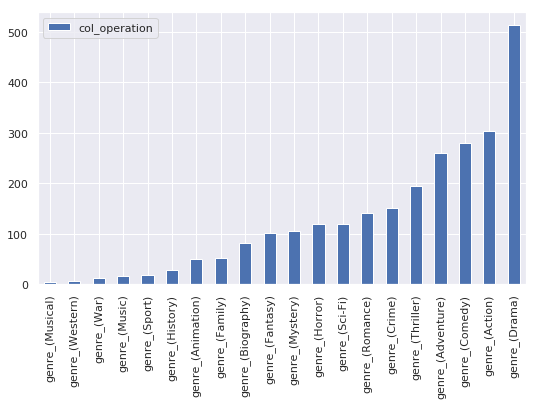

In [10]:
sum_genre = col_operation(genres, 'sum')
plot(x = sum_genre, style = 'barplot')

So, after we counted GENRES separately, we want to find how RATING is affected per GENRE.

Now, since the table is just 1s and 0s (for count), we want to MULTIPLY GENRES table with RATING.

In [11]:
M = multiply(genres, data['rating'])
head(M, 10)

,genre_(Action),genre_(Adventure),genre_(Animation),genre_(Biography),genre_(Comedy),genre_(Crime),genre_(Drama),genre_(Family),genre_(Fantasy),genre_(History),genre_(Horror),genre_(Music),genre_(Musical),genre_(Mystery),genre_(Romance),genre_(Sci-Fi),genre_(Sport),genre_(Thriller),genre_(War),genre_(Western)
0,8.100,8.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8.100,0.000,0.000,0.000,0.000
1,0.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000,7.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.300,0.000,0.000,0.000,0.000,0.000,0.000,7.300,0.000,0.000
3,0.000,0.000,7.200,0.000,7.200,0.000,0.000,7.200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,6.200,6.200,0.000,0.000,0.000,0.000,0.000,0.000,6.200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,6.100,6.100,0.000,0.000,0.000,0.000,0.000,0.000,6.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,8.300,0.000,8.300,0.000,0.000,0.000,0.000,8.300,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,6.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,7.100,7.100,0.000,7.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.000,7.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000


You can see how all the ratings are multiplied onto GENRES. Each row is the same number as ratings. but the whole point now is we want to have an AVERAGE rating PER GENRE!

So, how do we summarise columns? Use COL_OPERATION!

In [12]:
col_operation(M, 'mean')

genre_(Action)      2.004
genre_(Adventure)   1.754
genre_(Animation)   0.359
genre_(Biography)   0.591
genre_(Comedy)      1.855
genre_(Crime)       1.018
genre_(Drama)       3.567
                     ... 
genre_(Mystery)     0.730
genre_(Romance)     0.943
genre_(Sci-Fi)      0.806
genre_(Sport)       0.126
genre_(Thriller)    1.286
genre_(War)         0.096
genre_(Western)     0.047
Name: col_operation, Length: 20, dtype: float64

Theres a PROBLEMMM!!! Clearly, 0.07 rating is wayyyy too low. In fact, our MEAN failed.

It's because it counted all the zeros as a variable!

See below between what's WRONG and RIGHT:

<img src="https://drive.google.com/uc?id=1RdXbzxcqd7CJfdfjgvi6A1nCGWyoRQn8" style="width: 700px;"/>

So, instead of MEAN use MEAN_ZERO. (There's also COUNT_ZERO which omits all zeroes)

In [13]:
col_operation(M, 'mean_zero')

genre_(Action)      6.615
genre_(Adventure)   6.772
genre_(Animation)   7.324
genre_(Biography)   7.290
genre_(Comedy)      6.648
genre_(Crime)       6.787
genre_(Drama)       6.954
                     ... 
genre_(Mystery)     6.887
genre_(Romance)     6.686
genre_(Sci-Fi)      6.717
genre_(Sport)       7.011
genre_(Thriller)    6.593
genre_(War)         7.354
genre_(Western)     6.771
Name: col_operation, Length: 20, dtype: float64

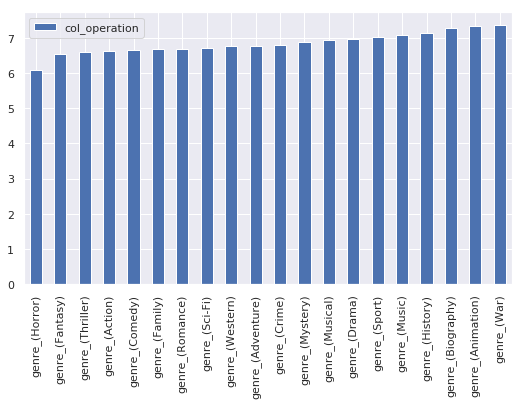

In [14]:
plot(col_operation(M, 'mean_zero'), style = 'barplot')

Clearly, WAR genre has the average highest, whilst HORROR the lowest average.

Next, we want to analyse DIRECTORS. Do they affect RATINGS??

We can use TALLY to see the count.

In [15]:
head(   tally(data['director'])   , 10)

,director,tally
0,Ridley Scott,8
1,David Yates,6
2,Michael Bay,6
3,Paul W.S. Anderson,6
4,M. Night Shyamalan,6
5,Martin Scorsese,5
6,Denis Villeneuve,5
7,Woody Allen,5
8,Danny Boyle,5
9,Peter Berg,5


Now, we clearly want to use MULTIPLE = TRUE in TALLY. But, the biggest problem is many directors direct once. We need to REMOVE all directors who directed say less than 4 movies.

This is because a 1 time shot at directing might not mean anything. But if you directed 4 movies or so, it could be indicative of your "real" rating.

Don't forget to remove all SPACES using REMOVE

In [16]:
data['director'] = remove(data['director'], ' ')
directors = tally(data['director'], multiple = True, min_count = 4)
head(directors, 10)

,director_(AdamMcKay),director_(AlexandreAja),director_(AntoineFuqua),director_(BenAffleck),director_(ChristopherNolan),director_(ClintEastwood),director_(D.J.Caruso),director_(DannyBoyle),director_(DavidFincher),director_(DavidO.Russell),director_(DavidYates),director_(DenisVilleneuve),director_(DennisDugan),director_(FrancisLawrence),director_(GoreVerbinski),director_(GuillermodelToro),director_(GuyRitchie),director_(J.J.Abrams),director_(JamesWan),director_(JoeWright),director_(JonFavreau),director_(JustinLin),director_(LarsvonTrier),director_(LouisLeterrier),director_(M.NightShyamalan),director_(MartinScorsese),director_(MatthewVaughn),director_(MichaelBay),director_(MikeFlanagan),director_(NicholasStoller),director_(PaulFeig),director_(PaulW.S.Anderson),director_(PeterBerg),director_(PeterJackson),director_(QuentinTarantino),director_(RidleyScott),director_(RobertZemeckis),director_(RonHoward),director_(StevenSpielberg),director_(TimBurton),director_(WoodyAllen),director_(ZackSnyder)
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, use COL_OPERATION after MULTIPLYING RATING, and see who wins!

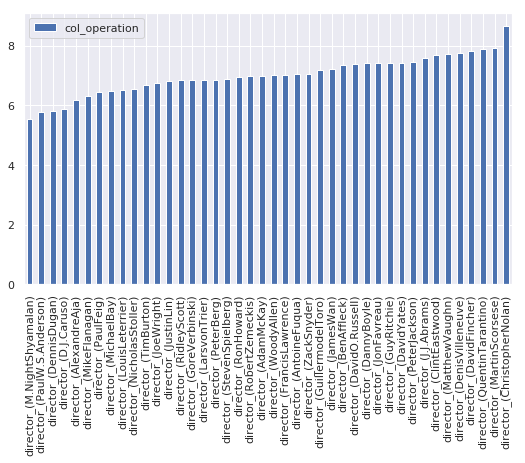

In [17]:
director_rating =     col_operation(   multiply(  directors,data['rating']   ),   'mean_zero')
plot(director_rating, style = 'barplot')

And how about ACTORS??? Same thing we do with directors. They must have performed in at least 5 films. (NOT 4 but 5)

Use SPLIT = ',' then TALLY MULTIPLE = TRUE then MULTIPLY and then COL_OPERATION (mean zero)

Also remove all SPACES using REMOVE

In [18]:
head(data['actors'], 5)

0    Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...
1    Noomi Rapace, Logan Marshall-Green, Michael Fa...
2    James McAvoy, Anya Taylor-Joy, Haley Lu Richar...
3    Matthew McConaughey,Reese Witherspoon, Seth Ma...
4    Will Smith, Jared Leto, Margot Robbie, Viola D...
Name: actors, dtype: object

In [19]:
data['actors'] = remove(data['actors'], ' ')
splits = split(data['actors'], ',')
sample(splits, 5)

510    [AsaButterfield, DavidThewlis, RupertFriend, Z...
498    [GerardButler, JamieFoxx, LeslieBibb, ColmMeaney]
590    [MichaelNyqvist, NoomiRapace, EwaFröling, Lena...
17     [MattDamon, TommyLeeJones, AliciaVikander, Vin...
352    [KateWinslet, JudyDavis, LiamHemsworth, HugoWe...
Name: actors, dtype: object

In [20]:
actors = tally(splits, multiple = True, min_count = 5)
tail(actors, 5)

,actors_(AaronEckhart),actors_(AaronTaylor-Johnson),actors_(AbbieCornish),actors_(AdamSandler),actors_(AliciaVikander),actors_(AmandaSeyfried),actors_(AmyAdams),actors_(AndrewGarfield),actors_(AndrewScott),actors_(AngelinaJolie),actors_(AnnaKendrick),actors_(AnneHathaway),actors_(AnthonyHopkins),actors_(AnthonyMackie),actors_(BenAffleck),actors_(BenFoster),actors_(BenKingsley),actors_(BenStiller),actors_(BillNighy),actors_(BlakeLively),actors_(BradPitt),actors_(BradleyCooper),actors_(BrendanGleeson),actors_(BrieLarson),actors_(BryanCranston),actors_(BryceDallasHoward),actors_(CameronDiaz),actors_(CaseyAffleck),actors_(CateBlanchett),actors_(ChanningTatum),actors_(CharlizeTheron),actors_(CharlotteGainsbourg),actors_(CharlotteLeBon),actors_(ChiwetelEjiofor),actors_(ChloëGraceMoretz),actors_(ChrisEvans),actors_(ChrisHemsworth),actors_(ChrisPine),actors_(ChrisPratt),actors_(ChristianBale),...,actors_(RooneyMara),actors_(RosamundPike),actors_(RosarioDawson),actors_(RoseByrne),actors_(RussellCrowe),actors_(RyanGosling),actors_(RyanReynolds),actors_(SamWorthington),actors_(SamuelL.Jackson),actors_(SandraBullock),actors_(SaoirseRonan),actors_(ScarlettJohansson),actors_(SethRogen),actors_(ShaileneWoodley),actors_(SharltoCopley),actors_(ShiaLaBeouf),actors_(SiennaMiller),actors_(SigourneyWeaver),actors_(SimonPegg),actors_(StellanSkarsgård),actors_(SteveCarell),actors_(SylvesterStallone),actors_(T.J.Miller),actors_(TeresaPalmer),actors_(TheoJames),actors_(TimRoth),actors_(TomCruise),actors_(TomHanks),actors_(TomHardy),actors_(VeraFarmiga),actors_(VinDiesel),actors_(VincentCassel),actors_(ViolaDavis),actors_(WillFerrell),actors_(WillSmith),actors_(WillemDafoe),actors_(WoodyHarrelson),actors_(ZacEfron),actors_(ZoeSaldana),actors_(ZoeyDeutch)
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's see the top 5 and bottom 5

In [21]:
actors_rating = multiply(actors, data['rating'])
actors_mean = col_operation(actors_rating, 'mean_zero')
actors_mean = sort(actors_mean)

In [22]:
actors_mean[0:10]

actors_(CameronDiaz)       5.480
actors_(KristenStewart)    5.712
actors_(KeanuReeves)       5.783
actors_(RobertPattinson)   5.800
actors_(KateBeckinsale)    5.817
actors_(AdamSandler)       5.844
actors_(DennisQuaid)       5.880
actors_(MeganFox)          6.020
actors_(ZoeyDeutch)        6.083
actors_(ZacEfron)          6.175
Name: col_operation, dtype: float64

<a id='Machine Learning - Supervised Learning'></a>
<h1> 4. Machine Learning - Supervised Learning</h1>

Finally, we get to make a model to predict RATINGS!!! We want to combine the data we have just made for ACTORS, DIRECTORS and GENRES.

First, we need to CONCATENATE all 3 new data with the original.

Use HCAT.

In [23]:
X = hcat(data, actors, directors, genres)

Now, we want to CLEAN the data. Machine Learning models require that there are NO missing values.

Also, ID columns (rank in this case) need to be removed.

All TEXT / OBJECT columns must be removed.

Essentially, only NUMBERS can remain.

Use CLEAN

In [24]:
X = clean(X)

In [25]:
help(clean)

Help on function clean in module __main__:

clean(data, missing='mean', remove_id=True)
    Cleans entire dataset.
    1. missing =
        mean, max, median, min
        Fills all missing values with column mean/median etc
    
    2. remove_id = True/False
        Checks data to see if theres an ID column.
        Removes it (not perfect)



Now, we want the data to predict RATING.

Remove RATING from X using normal column selecting, and remove it from X using EXCLUDE.

Also remove METASCORE (might be influencing on real RATING)

In [26]:
head(X)

,year,runtime_(minutes),rating,votes,revenue_(millions),metascore,actors_(AaronEckhart),actors_(AaronTaylor-Johnson),actors_(AbbieCornish),actors_(AdamSandler),actors_(AliciaVikander),actors_(AmandaSeyfried),actors_(AmyAdams),actors_(AndrewGarfield),actors_(AndrewScott),actors_(AngelinaJolie),actors_(AnnaKendrick),actors_(AnneHathaway),actors_(AnthonyHopkins),actors_(AnthonyMackie),actors_(BenAffleck),actors_(BenFoster),actors_(BenKingsley),actors_(BenStiller),actors_(BillNighy),actors_(BlakeLively),actors_(BradPitt),actors_(BradleyCooper),actors_(BrendanGleeson),actors_(BrieLarson),actors_(BryanCranston),actors_(BryceDallasHoward),actors_(CameronDiaz),actors_(CaseyAffleck),actors_(CateBlanchett),actors_(ChanningTatum),actors_(CharlizeTheron),actors_(CharlotteGainsbourg),actors_(CharlotteLeBon),actors_(ChiwetelEjiofor),...,director_(LarsvonTrier),director_(LouisLeterrier),director_(M.NightShyamalan),director_(MartinScorsese),director_(MatthewVaughn),director_(MichaelBay),director_(MikeFlanagan),director_(NicholasStoller),director_(PaulFeig),director_(PaulW.S.Anderson),director_(PeterBerg),director_(PeterJackson),director_(QuentinTarantino),director_(RidleyScott),director_(RobertZemeckis),director_(RonHoward),director_(StevenSpielberg),director_(TimBurton),director_(WoodyAllen),director_(ZackSnyder),genre_(Action),genre_(Adventure),genre_(Animation),genre_(Biography),genre_(Comedy),genre_(Crime),genre_(Drama),genre_(Family),genre_(Fantasy),genre_(History),genre_(Horror),genre_(Music),genre_(Musical),genre_(Mystery),genre_(Romance),genre_(Sci-Fi),genre_(Sport),genre_(Thriller),genre_(War),genre_(Western)
0,2014,121,8.100,757074,333.130,76.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2012,124,7.000,485820,126.460,65.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2016,117,7.300,157606,138.120,62.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,2016,108,7.200,60545,270.320,59.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2016,123,6.200,393727,325.020,40.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,2016,103,6.100,56036,45.130,42.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,2016,128,8.300,258682,151.060,93.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
7,2016,89,6.400,2490,82.956,71.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2016,141,7.100,7188,8.010,78.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2016,116,7.000,192177,100.010,41.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [27]:
Y = X['rating']
X = exclude(X, ['rating','metascore'])

Next, notice how YEAR abd VOTES are on WRONG SCALES. For machine learning models to succeed, they must be on the SAME SCALE.

Remember STANDARDISATION from last week? We remove the MEAN and divide by STANDARD DEVIATION.

A refresher:

<img src="https://drive.google.com/uc?id=1lzY11RT7Yi_u69eWnH9WYNlao2qw_0Rq" style="width: 300px;"/>

<img src="http://www.statistics4u.info/fundstat_eng/img/example_ztransform.png" style="width: 500px;"/>

Also, we want to use a LINEAR MODEL to model the interaction between the data X and the target Y. But what is a LINEAR MODEL?

It's a system which tries to fit a STRAIGHT LINE in any dimensional space!

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/1200px-Linear_regression.svg.png" style="width: 500px;"/>

<img src="https://drive.google.com/uc?id=1dMdJh99jbw8hD0_DEtiw0SbYjZupAN6_" style="width: 500px;"/>

Use the LINEARMODEL method.

Set SCALE = TRUE to auto scale the data.

In [28]:
model = LinearModel(scale = True)

Now, we want to FIT a model. Use model.fit(X,Y). We want to create a model mapping X to Y.

In [29]:
model.fit(X, Y)

Model now fitting...
Model finished fitting


Then, we want predictions. Use model.PREDICT(X).

It'll do auto scaling if it was specified to do so.

In [30]:
predictions = model.predict(X)
print(predictions[0:10])

[8.2523195  6.98927343 5.94149362 6.97399721 6.03492054 6.08233468
 7.93963959 5.88486161 6.22995885 6.97345878]


Now, after we fit a linear model, we want to know whether it was a good model or not.

An easy way to check, is to plot the real Y as X and PREDICTED Y as Y, and see if they lay on a straight line.

The closer the line is to a 45 degree line, the better the prediction.

Use model.PLOT(predictions, real_Y)

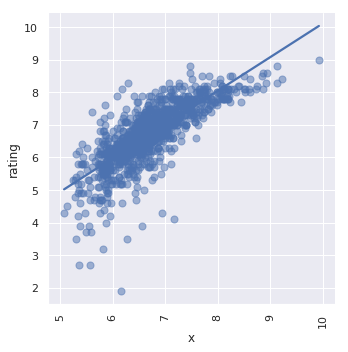

In [31]:
model.plot(predictions, Y)

Using model.COEFFICIENTS, and PLOT = TRUE with TOP = 50 (if no top, then too many rows will be outputted)

In [32]:
model.coefficients(plot = True, top = 50)

,Coefficient,Mean,Std,Range,Scale
director_(ChristopherNolan),-1.04134,,,"[0.0, 1.0]","[0.0, 1.0]"
genre_(Animation),0.978075,,,"[0.0, 1.0]","[0.0, 1.0]"
director_(QuentinTarantino),-0.869637,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(JavierBardem),-0.791189,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(KristenStewart),-0.742076,,,"[0.0, 1.0]","[0.0, 1.0]"
votes,0.649786,169808,188763,"[61.0, 36312.0, 240323.0, 1791916.0]","[-0.9, -0.71, 0.37, 8.59]"
director_(M.NightShyamalan),-0.633179,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(CameronDiaz),-0.629106,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(KurtRussell),0.599566,,,"[0.0, 1.0]","[0.0, 1.0]"
director_(D.J.Caruso),-0.555448,,,"[0.0, 1.0]","[0.0, 1.0]"


Negative means a BAD influence on RATING. Positive means a GOOD influence.

Note - in terms of interpretation, BE VERY VERY CAREFUL. VERY CAREFUL.

The weights symbolise SCALED weights (since we standardised). This means a NEGATIVE doesnt necessarily mean "smaller = better"

You need to UNSCALE the data and see the weights impact.

There are also MEAN, STD, RANGE and SCALE columns.

MEAN means the mean of the column after scaling. STD is the standard deviation.

RANGE means original [minimum, .... maximum] of the data. It shows a snapshot of how the column looked it.

SCALE means scaled [minimum, .... maximum] of the data. It shows a snapshot of how the column looked it after it scaled.


<a id='Machine Learning - Interpretation Traps'></a>
<h1> 5. Machine Learning - Interpretation Traps</h1>

One of the most important things to do is Interpreting the results / coefficients. Let's get the top 10.

In [33]:
model.coefficients(plot = True, top = 10)

,Coefficient,Mean,Std,Range,Scale
director_(ChristopherNolan),-1.04134,,,"[0.0, 1.0]","[0.0, 1.0]"
genre_(Animation),0.978075,,,"[0.0, 1.0]","[0.0, 1.0]"
director_(QuentinTarantino),-0.869637,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(JavierBardem),-0.791189,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(KristenStewart),-0.742076,,,"[0.0, 1.0]","[0.0, 1.0]"
votes,0.649786,169808,188763,"[61.0, 36312.0, 240323.0, 1791916.0]","[-0.9, -0.71, 0.37, 8.59]"
director_(M.NightShyamalan),-0.633179,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(CameronDiaz),-0.629106,,,"[0.0, 1.0]","[0.0, 1.0]"
actors_(KurtRussell),0.599566,,,"[0.0, 1.0]","[0.0, 1.0]"
director_(D.J.Caruso),-0.555448,,,"[0.0, 1.0]","[0.0, 1.0]"


Now, VOTES is 0.66. What this means is if VOTES > mean (169808), each standard deviation above the mean (or +188668) contributes 0.66 to the RATING.

Now, director_(Christopher Nolan). Be careful. VERY VERY CAREFUL. It does NOT NECESSARILY mean Christopher Nolan is BAD (since negative). (or is he actually bad?)

Remember we found that he was one of the HIGHEST rated directors? Then why is the Linear Model providing a negative coefficient?


In [34]:
sort(director_rating, how = 'descending')[0:10]

director_(ChristopherNolan)   8.680
director_(MartinScorsese)     7.920
director_(QuentinTarantino)   7.900
director_(DavidFincher)       7.820
director_(DenisVilleneuve)    7.760
director_(MatthewVaughn)      7.725
director_(ClintEastwood)      7.700
director_(J.J.Abrams)         7.580
director_(PeterJackson)       7.475
director_(DavidYates)         7.433
Name: col_operation, dtype: float64

Hmmmm? What's going on?

Say we REMOVED NOLAN from the movies he directed. What'll happen to him?

Let's find out! (Next week, we'll continue on Linear Model interpretation - since it's very important).

Use ANALYSE Column = director_(ChristopherNolan), and PLOT = True

In [35]:
model.analyse(plot = True, column = 'director_(ChristopherNolan)')

,Coefficient,N,If Stays,Change if Removed,Stay,Best Combo,Best Addon,Best Contrib,Worst Combo,Worst Reduced,Worst Contrib
director_(ChristopherNolan),-1.04,5,8.89,-2.18,1,votes,3.95,6.05,revenue_(millions),-0.42,2.28


From ANALYSE, we can see if NOLAN is not directing the 5 films (from N), he actually we REDUCE the overall mean score by -2.17!!! (Change if Removed).

So, but why is the linear model saying he has a negative influence??

WE"LL DISCUSS NEXT WEEK ABOUT THIS.

<a id='Lab'></a>
<h1> 6. Lab Questions </h1>

<img src="https://previews.123rf.com/images/christianchan/christianchan1503/christianchan150300425/37144675--now-it-s-your-turn-note-pinned-on-cork-.jpg" style="width: 300px;"/>

1. Review the code above. Start from:
[Machine Learning - Supervised Learning](#Machine Learning - Supervised Learning)
2. I want you to instead of predicting RATING, predict REVENUE
3. This means 1. EXCLUDE REVENUE from the data
4. Scale the data.  [negative means below average, positive means above average]
5. Predict
6. Use ANALYSE on the HIGHEST coefficient >> USE COEFFICIENT. and LOWEST coefficient and CONFIRM your findings.
7.  In the future, if you wanted to make a GOOD movie, what would you recommend to say Disney or 20th Century Fox Studios?

Model now fitting...
Model finished fitting


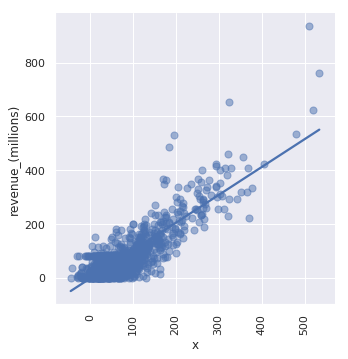

,Coefficient,N,If Stays,Change if Removed,Stay,Best Combo,Best Addon,Best Contrib,Worst Combo,Worst Reduced,Worst Contrib
director_(J.J.Abrams),131.01,5,310.49,-228.67,1,votes,82.79,1.4,genre_(Sci-Fi),-8.56,0.6


In [73]:
# Your code goes here.
# hcat
#head(X,5)
FX = hcat(data, actors, directors, genres,'revenue_(millions)')
head(FX,5)
FX = clean(FX)
FY = FX['revenue_(millions)']
FX = exclude(X, ['revenue_(millions)','metascore'])
# remove columns
# scale
Fmodel = LinearModel(scale = True)
# model
Fmodel.fit(FX, FY)
Fpredictions = Fmodel.predict(FX)
    #print(Fpredictions[0:10])
# plot
Fmodel.plot(Fpredictions, FY)
# coefficients
Fmodel.coefficients(plot = True, top = 50)

# analyse
#highest
Fmodel.analyse(plot = True, column = 'director_(J.J.Abrams)')
#loest
Fmodel.analyse(plot = True, column = 'director_(ChristopherNolan)')
# Then, recommendations to studios
#I recommend ChristopherNolan to be a directors, because it is obviously to see that, 
#if ChristopherNolan didn't direct movies, the REDUCE the overall mean score 
# by 237.04 millions!!! so he is the person who can make the movie make highest benefit.

In [69]:
#loest
Fmodel.analyse(plot = True, column = 'director_(ChristopherNolan)')

,Coefficient,N,If Stays,Change if Removed,Stay,Best Combo,Best Addon,Best Contrib,Worst Combo,Worst Reduced,Worst Contrib
director_(ChristopherNolan),-78.97,5,318.81,-237.04,1,votes,356.53,6.05,genre_(Drama),-2.74,0.6


<h2>ASSIGNMENT 1 (week 3 to 5) 7 marks - DUE WEEK 5 SATURDAY 10pm</h2>

Assignment 1 is due Saturday week 5 10pm. We need you to submit a URL / LINK to your assignment notebook on Kaggle.

IT MUST BE **PUBLIC**. Also, download the Kaggle file, and upload it to Moodle by 10pm Saturday week 5.
